In [1]:
import numpy as np
import pandas as pd
import time
import tensorflow as tf

import pathlib
import shutil
import tempfile

In [2]:
!pip install tensorflow_hub
!pip install tensorflow_datasets
!pip install -q git+https://github.com/tensorflow/docs

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/apps/USE/easybuild/release/2021.3/software/Python/3.9.5-GCCcore-10.3.0/bin/python3.9 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/apps/USE/easybuild/release/2021.3/software/Python/3.9.5-GCCcore-10.3.0/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/apps/USE/easybuild/release/2021.3/software/Python/3.9.5-GCCcore-10.3.0/bin/python3.9 -m pip install --upgrade pip' command.


In [3]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display
%matplotlib inline

import pathlib
import shutil
import tempfile
import os

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from sklearn.model_selection import train_test_split

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
print('Number of GPUs :',len(tf.config.list_physical_devices('GPU')))

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

Version:  2.6.0
Hub version:  0.12.0
GPU is available
Number of GPUs : 4


In [4]:
if os.path.exists('dataset.pkl'):
    df = pd.read_pickle('dataset.pkl')
else:
    df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', 
             compression='zip', low_memory=False)
    df.to_pickle('dataset.pkl')
df.shape

(1306122, 3)

<AxesSubplot:title={'center':'Target distribution'}, ylabel='Frequency'>

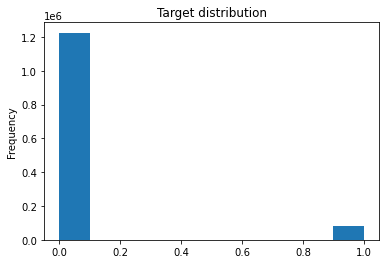

In [5]:
df['target'].plot(kind='hist', title='Target distribution')

In [6]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.1, stratify=df.target.values)
valid_df, _  = train_test_split(remaining, random_state=42, train_size=0.001, stratify=remaining.target.values)
print(train_df.shape, valid_df.shape)

(130612, 3) (1175, 3)


In [16]:
buffer_size = train_df.size
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices((train_df.question_text.values, train_df.target.values)).shuffle(buffer_size).batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values)).batch(batch_size)

In [18]:
num = 0;
for x, y in train_dataset:
    num += 1
print(num)
train_df.shape[0]//256 + 1

511


511

In [ ]:
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
embeding_size = 128
name_of_model = 'nnlm-en-dim128'

In [ ]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
    hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape=[embed_size], dtype = tf.string, trainable=trainable)
    model = tf.keras.models.Sequential([
                                      hub_layer,
                                      tf.keras.layers.Dense(256, activation='relu'),
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss = tf.losses.BinaryCrossentropy(),
                metrics = [tf.metrics.BinaryAccuracy(name='accuracy')])
    history = model.fit(train_dataset,
                      epochs = 100,
                      validation_data=valid_dataset,
                      callbacks=[tfdocs.modeling.EpochDots(),
                                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'),
                                 tf.keras.callbacks.TensorBoard(logdir/name)],
                      verbose = 0
                      )
    return history

In [ ]:
histories = {}

In [ ]:
start = time.time()
histories[name_of_model] = train_and_evaluate_model(module_url, embed_size=embeding_size, name=name_of_model)
endt = time.time()-start
print("\n \n Time for {} ms".format(1000*endt))

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {logdir} --host mel2038 --port 8888